#### Import Libraries

In [149]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### Read in data

In [150]:
df = pd.read_csv("UsArrests.csv", index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


I made the index equal to the state because that is already a unique identifier, therefore a numbered index was not needed.

### Cleaning the Dataset

#### Renaming the columns

In [151]:
df.index.names = ['States']
df.rename(columns={'UrbanPop':'UrbanPop(%)'}, inplace=True)

In [152]:
df.head()

,Murder,Assault,UrbanPop(%),Rape
States,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


- The entries in the index column were states and not cities, so I decided to rename it to be more accurate.
- Since the other columns represent residents per 100,000 whereas UrbanPop was a percentage, I decided the make that clear

#### Gathering the shape of the dataset

In [153]:
print('Number of cases: {}\nNumber of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50
Number of features: 4


#### Determine if there are any missing values

In [154]:
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["Missing"])
relevant_missing

,Missing
Murder,0
Assault,0
UrbanPop(%),0
Rape,0


Just in case a null value appears as something else, I'm gonna proceed to check all unique values present in the columns.

In [155]:
for n in df.columns:
    check = df[n].unique()
    print(f'{n}:\n', sorted(check), '\n')

Murder:
 [0.8, 2.1, 2.2, 2.6, 2.7, 3.2, 3.3, 3.4, 3.8, 4.0, 4.3, 4.4, 4.9, 5.3, 5.7, 5.9, 6.0, 6.3, 6.6, 6.8, 7.2, 7.3, 7.4, 7.9, 8.1, 8.5, 8.8, 9.0, 9.7, 10.0, 10.4, 11.1, 11.3, 11.4, 12.1, 12.2, 12.7, 13.0, 13.2, 14.4, 15.4, 16.1, 17.4] 

Assault:
 [45, 46, 48, 53, 56, 57, 72, 81, 83, 86, 102, 106, 109, 110, 113, 115, 120, 145, 149, 151, 156, 159, 161, 174, 178, 188, 190, 201, 204, 211, 236, 238, 249, 252, 254, 255, 259, 263, 276, 279, 285, 294, 300, 335, 337] 

UrbanPop(%):
 [32, 39, 44, 45, 48, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 68, 70, 72, 73, 74, 75, 77, 78, 80, 81, 83, 85, 86, 87, 89, 91] 

Rape:
 [7.3, 7.8, 8.3, 9.3, 9.5, 10.8, 11.1, 11.2, 11.3, 12.8, 14.2, 14.9, 15.6, 15.8, 16.1, 16.3, 16.4, 16.5, 17.1, 18.0, 18.8, 19.5, 20.0, 20.2, 20.7, 21.0, 21.2, 21.4, 22.2, 22.5, 22.9, 24.0, 25.5, 25.8, 26.1, 26.2, 26.9, 27.8, 28.2, 29.3, 31.0, 31.9, 32.1, 35.1, 38.7, 40.6, 44.5, 46.0] 



A dataset with no missing values, just my lucky day!

####  Determine the column types

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Murder       50 non-null     float64
 1   Assault      50 non-null     int64  
 2   UrbanPop(%)  50 non-null     int64  
 3   Rape         50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [157]:
df['UrbanPop(%)'] = df['UrbanPop(%)'].astype(float)
df['Assault'] = df['Assault'].astype(float)

Since Murder and Rape were floats, I thought that it would make sense to also convert Assault and UrbanPop to float too.
It wouldn't make sense to convert them all to integers because then you would lose data.

### Exploring the data

#### Gathering an insight into the statistical properties

In [158]:
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.788,4.356,0.800,17.400
Assault,170.760,83.338,45.000,337.000
UrbanPop(%),65.540,14.475,32.000,91.000
Rape,21.232,9.366,7.300,46.000


From this we can gather that assault overshadows the rest by a substantial amount, just by looking at everything to do with it, especially since its standard deviation is more than the max of murder and rape put together. This makes sense, since assault is considered to be a lesser crime compared to the others and can even lead up to them. In the same fashion that weed is the gateway drug, assault can be seen as the gateway offence here. Due to this, scaling may need to be introduced to balance out this disproportion.

#### Observing the distributions

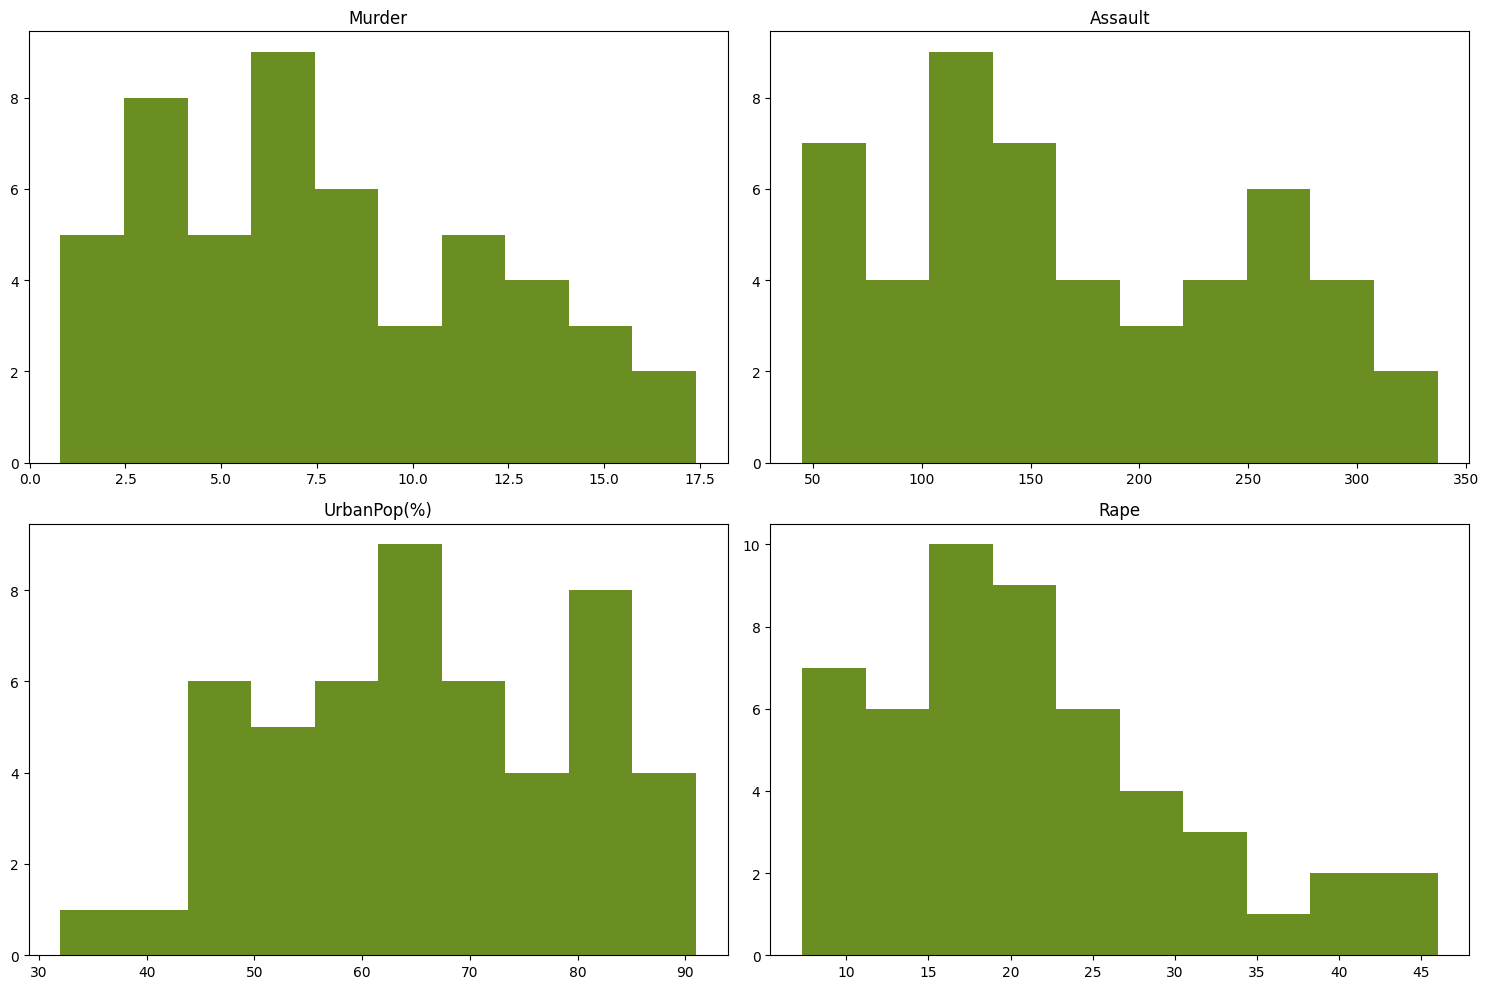

In [159]:
histograms = df.hist(color='olivedrab', grid=False, figsize=(15, 10))
plt.tight_layout()

As we can see here, thankfully most of the offences committed are towards the lower end of scale. Quite interestingly however there seems to be a drop off point in all three somewhere in the middle and then a spike towards the right hand side. This could suggest a country wide baseline for crimes being toward the lower end of the scale, with perhaps a few states being particularly bad for it and therefore resulting in the spike towards the higher end. This could be due to a poor police force, political unrest, vast unemployment, drug epidemic or maybe some other reason. On a seperate note the Urban Population percentage seems to follow a normal distribution which is slightly skewed towards the right hand side which makes sense since it is a developed and rich country.

#### Correlation Analysis

<AxesSubplot: >

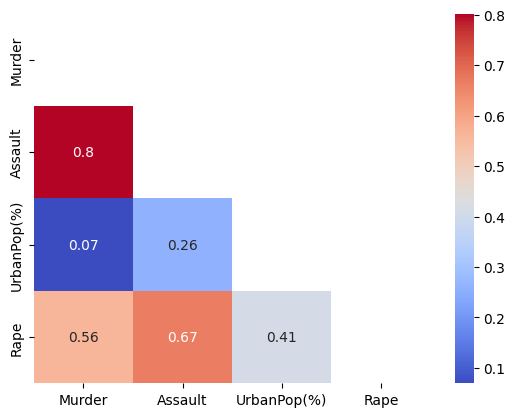

In [160]:
# Creates the correlation matrix
corr_matrix = df.corr()

# Is a mask to hide the top right hand side of the matrix (repeated, redundant)
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plots the heatmap, changes the colour scheme and adds annotations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)

Looking at this correlation heatmap we can determine:
- All correlation coefficients are positive.


- Murder and Assault have a very high positive correlation, meaning that states with a high assault rate tend to also have a high murder rate. I think this is because an assault is very likely to lead into a murder if they get carried away in the moment.


- Rape and Murder seem to have a partial positive correlation, nowhere near as strong as assault but still present.


- Rape and assault as mentioned before has a slightly higher positive correlation than murder and rape, I think this may be due to the fact that assault is likely to lead to murder or rape but rarely both.


- Interestingly enough though there doesn't seem to be any discernable correlation between urban population and any of the offences, except maybe rape. This is a surpise to me since I would have thought that the more densely packed a population is the more likely it would be for crimes to be commited.

### PCA

#### Define the function to create a biplot

In [161]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

#### Assigning variable

In [162]:
X = df.values.squeeze()

#### Standardise the data

In [163]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Establish the PCA model

In [164]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#### Display results in a biplot

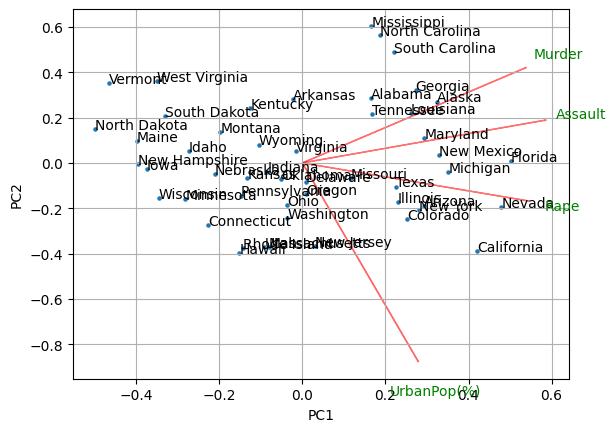

In [165]:
states = df.index
biplot(X_pca, pca.components_.T, labels=df.columns, points=df.index)

What I can gather from this is that a fair amount of states just don't seem to have a horrible problem with crime, but the ones that do go all in it seems

#### Feature importance

In [166]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = df.columns
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop(%),0.278,0.873
3,Rape,0.543,0.167


This shows the importance of each feature, and the contribution seems fairly equal.
- UrbanPop(%) dominates the pc2 importance.


- Assault has the most importance in pc1, however murder is more of an all rounder with an equal spread of importance in pc1 and pc2.

#### Cumulative Explained Variance

Text(0, 0.5, 'Cumulative explained variance')

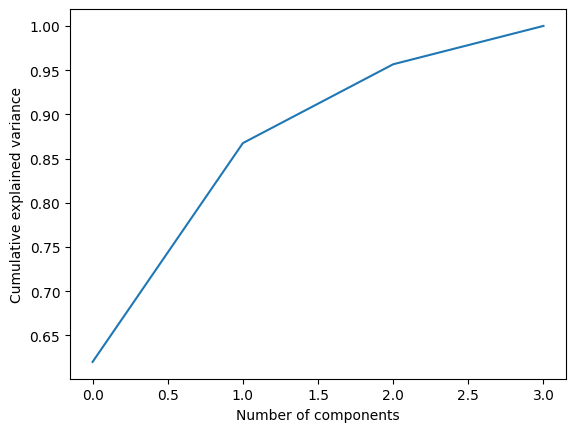

In [167]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

As you can see, most of the variance is summed up by just 2 components, around 95%.

This suggests that most of the data may be highly correlated, and that much of the information in the data can be represented by just 2 features.

### Hierarchical clustering

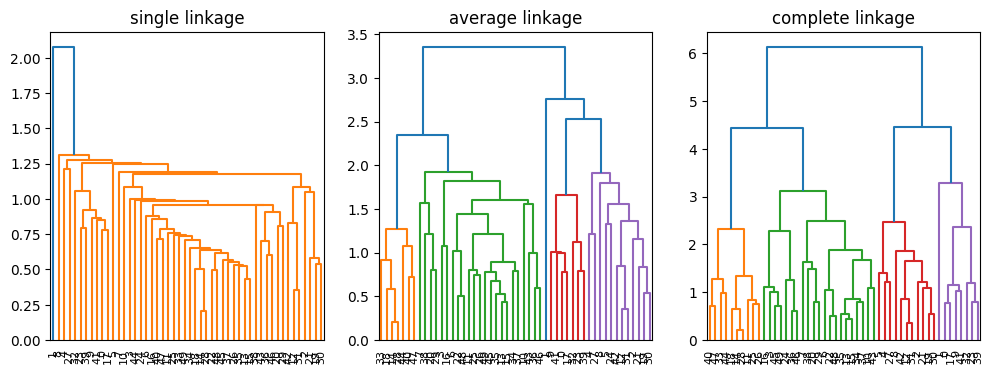

In [168]:
# Set figure size and subplot width to an equal ratio
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])

# define the linkage types
linkage_types = ['single', 'average', 'complete']

# Loop through each linkage type
for i, l in enumerate(linkage_types):
    
    # Creating a new plot for each linkage type
    ax = fig.add_subplot(gs[0, i])
        
    # Perform hierarchical clustering with the current linkage type
    dend = dendrogram(linkage(X_pca, method=l))
  
    # Set plot title
    plt.title('{} linkage'.format(l))

- So as we can see from the above plots, single linkage is absolutely useless here.


- Average linkage does fairly well in discerning the different groups, however seems to mess it up slightly by discerning a 5 group, unless this is some sort of outlier or mold-breaker in a league of its own.


- Complete linkage however does an outstanding job of elegantly arranging the different clusters. Just look at how neat and clear it looks.

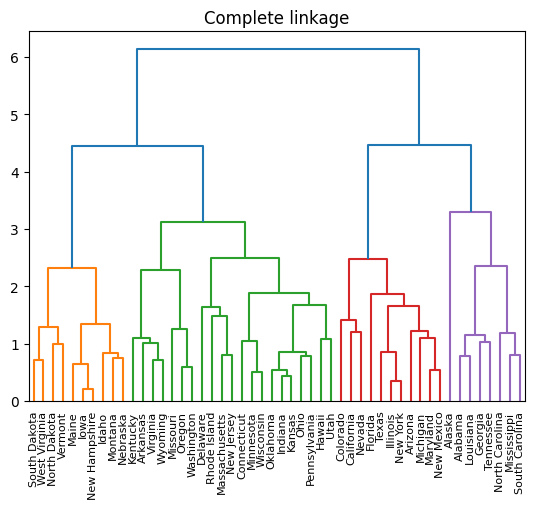

In [169]:
plt.title('Complete linkage')
dendrogram(linkage(X_pca, method='complete'), labels=df.index)
plt.show()

The Winner! Complete linkage takes the stage!

Here I make it more visible and even add the labels which tell you which state is where. It seems pretty clear that there are 4 different clusters here.

### K-means Clustering

 #### Extract components

In [170]:
x = X_pca[:,0]
y = X_pca[:,1]

#### Fit k-means

In [176]:
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

C:\Users\Joshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Plot clusters

Text(0, 0.5, 'Dimension 2')

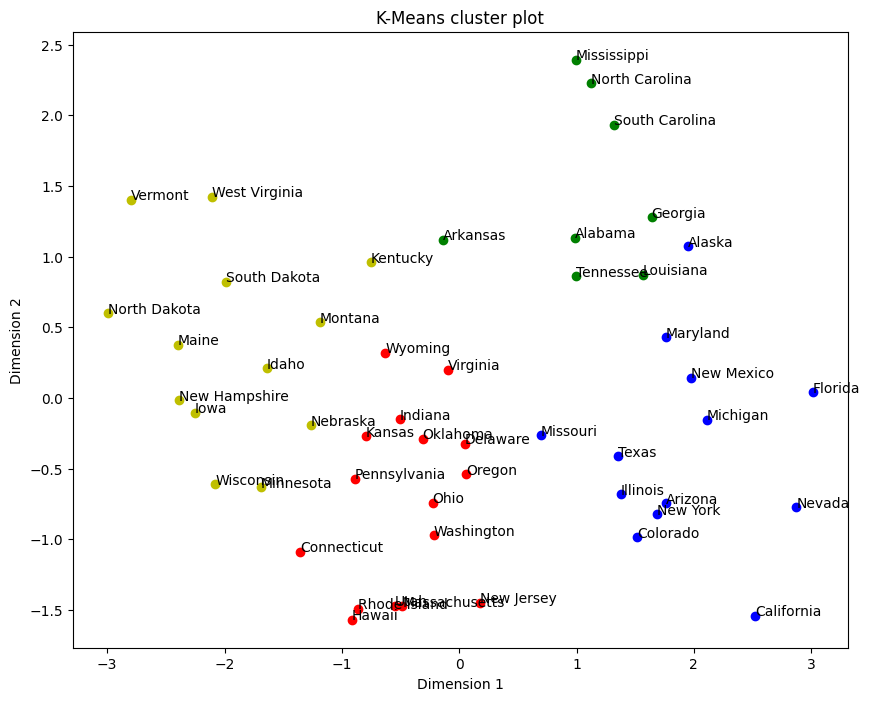

In [183]:
fig, ax = plt.subplots(figsize=(10, 8))
colours = 'rgby'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

Since there are a few overlapping states, I'll format them below to be more readable.

#### Displaying cluster members in a more readable fashion

In [178]:
for i in range(k):
    print(f"Cluster {i+1}:")
    for state in states[cluster_labels == i]:
        print(f"• {state}")
    print()

Cluster 1:
• Connecticut
• Delaware
• Hawaii
• Indiana
• Kansas
• Massachusetts
• New Jersey
• Ohio
• Oklahoma
• Oregon
• Pennsylvania
• Rhode Island
• Utah
• Virginia
• Washington
• Wyoming

Cluster 2:
• Alabama
• Arkansas
• Georgia
• Louisiana
• Mississippi
• North Carolina
• South Carolina
• Tennessee

Cluster 3:
• Alaska
• Arizona
• California
• Colorado
• Florida
• Illinois
• Maryland
• Michigan
• Missouri
• Nevada
• New Mexico
• New York
• Texas

Cluster 4:
• Idaho
• Iowa
• Kentucky
• Maine
• Minnesota
• Montana
• Nebraska
• New Hampshire
• North Dakota
• South Dakota
• Vermont
• West Virginia
• Wisconsin



Cluster 1: This cluster may have states with lower crime rates and arrests, which could be attributed to factors such as higher levels of education, a more liberal and progressive outlook, and better socio-economic conditions. In general, the states in this cluster may also tend to have higher median incomes, better-educated populations, and more liberal political leanings.

Cluster 2: This cluster may have states with higher rates of violent crime and arrests, which could be related to factors such as poverty, gang activity, drug trafficking, and urbanisation. In general, the states in this cluster may also tend to be socially conservative, have a history of racial segregation and discrimination, and have lower median incomes and education levels. The geography of this cluster also seems very close together, located predominantly in the southeastern region of the country, which has a history of being a part of the Confederacy during the Civil War.

Cluster 3: This cluster may have states with higher rates of property crimes and arrests, which could be associated with factors such as urbanisation, poverty, and income inequality. In general, the states in this cluster may also tend to be more diverse, have higher population densities, and be more politically liberal.

Cluster 4: This cluster may have states with moderate crime rates but with higher concentrations of specific types of crimes, such as rape or drug offenses. In general, the states in this cluster may also tend to have lower population densities, be more rural, and have higher rates of substance abuse and addiction.

These are however general observations that I have made from articles I have found on the internet, obviously I do not know Northern American geography or the culture there that well at all and are therefore depending on what I can derive from online. I truly am at the mercy of whatever articles appear first, hoping they're unbiased. 

Therefore the reasons here may not be accurate in the slightest.